In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = False

# NOTES
NOTES = ""

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "DNN"
OUTSTR = "A{:.4f}_TA{:.4f}_Type{}_HU{}_LR{}_S{}_B{}{}.csv"
NUM_LABELS = 10
IMG_DIM = 28
LEARNING_STEPS = 2500
LEARNING_RATE = 0.05
BATCH_SIZE = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [2]:
def nearest_2(n):
    if n < 1:
        return 1
    l = int(math.log(n, 2))
    a, b = 2 ** l, 2 ** (l + 1)
    return (a if (n - a) <= (b - n) else b)

def parse_labels_and_features(dataset):
    labels = dataset[target_label].astype(np.int32)
    features = dataset.iloc[:,1:785]
    features = features / 255
    return (pd.DataFrame({"label":labels}), features)

def summarize(dataframe, m=""):
    if SUMMARIZE:
        if m:
            print(m)
        print(dataframe.info())
        display.display(dataframe.describe())
        
def cleanup(df):
    copy = pd.DataFrame()
    for label in df.columns:
        if label == target_label or (label.startswith("pixel") and df[label].max() != 0.0):
            copy[label] = df[label]
    return (copy)

def construct_feature_columns():
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  def _input_fn(num_epochs=None, shuffle=True):
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = labels.reindex(idx)
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(10000)
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

def create_predict_input_fn(features, labels, batch_size):
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = steps // 100
    steps_per_period = steps // periods  
    
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        hidden_units = hidden_units,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...\nMetrics:")
    print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
    training_accuracies = []
    validation_accuracies = []
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        training_targets_one_hot = tf.keras.utils.to_categorical(training_targets,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)  
        validation_targets_one_hot = tf.keras.utils.to_categorical(validation_targets,10)  

        # Compute training and validation errors.
        training_log_loss = log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = log_loss(validation_targets, validation_pred_one_hot)
        training_accuracy = 100 * accuracy_score(training_targets_one_hot, training_pred_one_hot)
        validation_accuracy = 100 * accuracy_score(validation_targets_one_hot, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, training_log_loss, validation_log_loss))
        print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(training_accuracy, validation_accuracy))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = 100 * accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(training_accuracies, label="training")
    plt.plot(validation_accuracies, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    return (classifier, accuracy)

Input Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42000 entries, 1338 to 15933
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.9 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0
mean,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.3,4.6,3.3,1.8,1.9,0.4,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.0,254.0,253.0,253.0,254.0,62.0,0.0,0.0,0.0,0.0


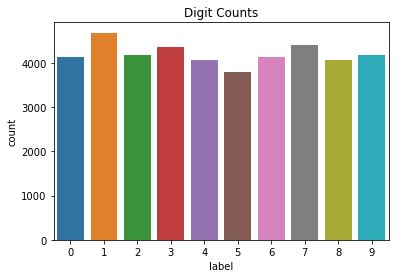

In [3]:
# Read in the raw dataset
df = pd.read_csv(paths["Training"], sep=",")
df = df.reindex(np.random.permutation(df.index))
if TEST:
    df = df.head(1500)
summarize(df, m="Input Data")
ax = sns.countplot(x="label", data=df)
ax.set_title("Digit Counts")

# Split dataset 80/20 for training and validation
df_size = df.shape[0]
t_size = int(0.8 * df_size)
v_size = df_size - t_size
training_targets, training_examples = parse_labels_and_features(df.head(t_size))
validation_targets, validation_examples = parse_labels_and_features(df.tail(v_size))

In [4]:
summarize(training_examples, "Training Data")
summarize(training_targets, "Training Targets")

Training Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33600 entries, 1338 to 39555
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 201.2 MB
None


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,...,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.7,1.0,0.2,0.0,0.0,0.0,0.0


Training Targets
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33600 entries, 1338 to 39555
Data columns (total 1 columns):
label    33600 non-null int32
dtypes: int32(1)
memory usage: 393.8 KB
None


,label
count,33600.0
mean,4.5
std,2.9
min,0.0
25%,2.0
50%,4.0
75%,7.0
max,9.0


In [5]:
summarize(validation_examples, "Validation Data")
summarize(validation_targets, "Validation Targets")

Validation Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 15783 to 15933
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 50.3 MB
None


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,...,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0


Validation Targets
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 15783 to 15933
Data columns (total 1 columns):
label    8400 non-null int32
dtypes: int32(1)
memory usage: 98.4 KB
None


,label
count,8400.0
mean,4.5
std,2.9
min,0.0
25%,2.0
50%,4.0
75%,7.0
max,9.0


[128, 32, 16]
Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	4.40	4.61
		Acc.	87.25%	86.64%

	1	LgLs	2.96	3.32
		Acc.	91.44%	90.38%

	2	LgLs	1.90	2.20
		Acc.	94.50%	93.62%

	3	LgLs	1.36	1.79
		Acc.	96.06%	94.81%

	4	LgLs	1.54	1.90
		Acc.	95.55%	94.51%

	5	LgLs	1.17	1.62
		Acc.	96.62%	95.31%

	6	LgLs	0.93	1.43
		Acc.	97.30%	95.86%

	7	LgLs	1.15	1.67
		Acc.	96.66%	95.18%

	8	LgLs	0.86	1.36
		Acc.	97.52%	96.07%

	9	LgLs	0.74	1.21
		Acc.	97.86%	96.49%

	10	LgLs	0.83	1.37
		Acc.	97.59%	96.04%

	11	LgLs	0.80	1.33
		Acc.	97.68%	96.15%

	12	LgLs	0.66	1.27
		Acc.	98.08%	96.33%

	13	LgLs	0.50	1.11
		Acc.	98.55%	96.79%

	14	LgLs	0.54	1.16
		Acc.	98.44%	96.63%

	15	LgLs	0.46	1.11
		Acc.	98.66%	96.80%

	16	LgLs	0.44	1.06
		Acc.	98.73%	96.93%

	17	LgLs	0.44	1.06
		Acc.	98.73%	96.93%

	18	LgLs	0.36	1.10
		Acc.	98.94%	96.81%

	19	LgLs	0.35	1.04
		Acc.	98.99%	96.99%

	20	LgLs	0.29	0.95
		Acc.	99.15%	97.25%

	21	LgLs	0.32	0.95
		Acc.	99.08%	97.24%

	22	LgLs	0.23	0.89
		Acc.	99.32%	97.42%


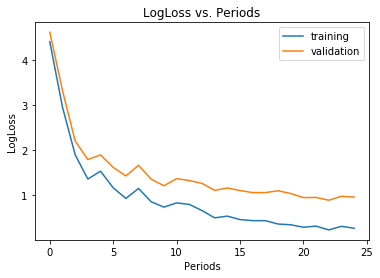

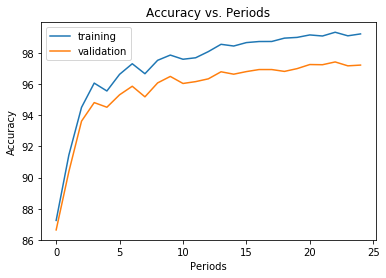

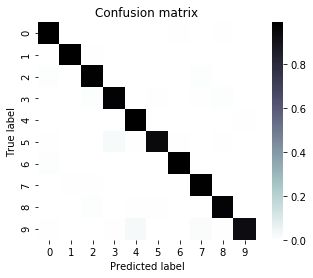

In [6]:
layers = 3
units = [nearest_2(math.ceil(t_size ** (1/i))) for i in range(2, 2+layers)]
print(units)
unitstr = "_".join([str(x) for x in units])

classifier, accuracy = train_nn_classification_model(
    learning_rate=LEARNING_RATE,
    steps=LEARNING_STEPS,
    hidden_units=units,
    batch_size=BATCH_SIZE,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [7]:
test_examples = pd.read_csv(paths["Testing"], sep=",")
test_targets = pd.read_csv(paths["Submission"], sep=",")
ids = test_targets[id_label]

summarize(test_examples)
summarize(test_targets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.5,3.6,1.8,1.2,0.8,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.0,254.0,193.0,187.0,119.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
ImageId    28000 non-null int64
Label      28000 non-null int64
dtypes: int64(2)
memory usage: 437.6 KB
None


,ImageId,Label
count,28000.0,28000.0
mean,14000.5,0.0
std,8083.0,0.0
min,1.0,0.0
25%,7000.8,0.0
50%,14000.5,0.0
75%,21000.2,0.0
max,28000.0,0.0


In [8]:
fn = create_predict_input_fn(test_examples, test_targets, batch_size=50)
predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

In [16]:
t_accuracy = 100 * accuracy_score(test_targets["Label"], predictions)
print("Final accuracy (on test data compared to sample submission): %0.4f%%" % t_accuracy)
if not TEST:
    name = OUTSTR.format(accuracy, t_accuracy, TYPE, unitstr, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
    print("Outputting to: '{}'".format(name))
    output.to_csv(name, index=False)

Final accuracy (on test data compared to sample submission): 9.9821%
Outputting to: 'A97.2143__TA9.9821_TypeDNN_HU128_32_16_LR0.05_S2500_B100.csv'
